Packages

keras

In [23]:
#tensorflow: use some TF tools
import tensorflow as tf
#Keras: Deep learning API. In TF 2.x, it is included in TF
from tensorflow import keras
from tensorflow.keras.models import Sequential


#Import Dense layer
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC

# import RNN SimpleRNN
from tensorflow.keras.layers import SimpleRNN,SpatialDropout1D


import os

# ROC from skilearn
from sklearn.metrics import roc_auc_score

import pandas as pd

import matplotlib.pyplot as pyplot
%matplotlib inline


Hyper parameters

In [2]:
output_dir = "model_output/rnn"

# Training
epochs = 16
batch_size = 128

# vector space embed
n_dim = 64 #vector dimensions
n_unique_words = 10000
n_words_to_skip = 50
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # drop out for embedding layer

# RNN
n_rnn = 256
drop_rnn = 0.2

# Dense layer
n_dense = 256
dropout = 0.2

IMDb

In [3]:
from tensorflow.keras.datasets import imdb

In [4]:
#imdb.get_word_index()

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

Load IMDb

In [6]:
(x_train, y_train), (x_valid, y_valid) = \
    imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

In [7]:
print(len(x_train))
print(len(x_valid))

25000
25000


In [8]:
len(x_train[0])

218

In [9]:
y_train[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [10]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [10]:
word_indexes = imdb.get_word_index()
len(word_indexes)
#print(word_indexes)

88584

In [11]:
# Reserve 3 values (0, 1, 2) for special words
word_indexes = {k:(v+3) for k, v in word_indexes.items()}

In [12]:
# Add 3 special words
word_indexes["pad"] = 0
word_indexes["start"] = 1
word_indexes["unk"] = 2

In [13]:
word_indexes["unk"]

2

In [14]:
# Inverse key and values
index_word = {v:k for k, v in word_indexes.items()}

In [15]:
index_word[2]

'unk'

In [16]:
# print a sentence 
' '.join([index_word[id] for id in x_train[0]])

"unk unk unk unk unk brilliant casting location scenery story direction everyone's really suited unk part unk played unk unk could unk imagine being there robert unk unk unk amazing actor unk now unk same being director unk father came unk unk same scottish island unk myself unk unk loved unk fact there unk unk real connection unk unk unk unk witty remarks throughout unk unk were great unk unk unk brilliant unk much unk unk bought unk unk unk soon unk unk unk released unk unk unk would recommend unk unk everyone unk watch unk unk fly fishing unk amazing really cried unk unk end unk unk unk sad unk unk know what unk say unk unk cry unk unk unk unk must unk been good unk unk definitely unk also unk unk unk two little boy's unk played unk unk unk norman unk paul unk were unk brilliant children unk often left unk unk unk unk list unk think because unk stars unk play them unk grown up unk such unk big profile unk unk whole unk unk these children unk amazing unk should unk praised unk what u

In [17]:
# Pad to get same length
max_review_length
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
len(x_train[0])

100

Dense Network with Embedding

In [20]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) # Input: vector of 100 words
# Output: word vector with n_dim(64) dimensions
# unique words = 10000
# Output: 10000 * 64 = 640 000 parameters

In [24]:
# Embedding dropout
model.add(SpatialDropout1D(drop_embed))

In [25]:
#model.add(Flatten())
# Output: one dimensional vector for Dense Layer
# vector: 100 * 64 

In [26]:
# RNN layer
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))

In [27]:
# Dense: 6400 * 64 = 409 000 parameters + 64 biases 
#model.add(Dense(n_dense, activation="relu"))


In [28]:
#model.add(Dropout(dropout))

In [29]:
# Output layer: sigmoid, 2 classes: 0 and 1
model.add(Dense(1, "sigmoid"))
# 64 parameters (one for each preceding layer neurons) + 1 bias = 65 params

In [30]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
# Model Checkpoint: to save model parameters after each epoch
modelcheckpoint = ModelCheckpoint(filepath= output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [32]:
# Train
model.fit(x_train, y_train,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/16
25000/25000 [==============================] - 44s 2ms/sample - loss: 0.6977 - accuracy: 0.5174 - val_loss: 0.6936 - val_accuracy: 0.5278
Epoch 2/16
25000/25000 [==============================] - 43s 2ms/sample - loss: 0.6754 - accuracy: 0.5704 - val_loss: 0.6885 - val_accuracy: 0.5512
Epoch 3/16
25000/25000 [==============================] - 43s 2ms/sample - loss: 0.6029 - accuracy: 0.6694 - val_loss: 0.7552 - val_accuracy: 0.5934
Epoch 4/16
25000/25000 [==============================] - 42s 2ms/sample - loss: 0.5409 - accuracy: 0.7220 - val_loss: 0.5829 - val_accuracy: 0.6985
Epoch 5/16
25000/25000 [==============================] - 44s 2ms/sample - loss: 0.4683 - accuracy: 0.7796 - val_loss: 0.5901 - val_accuracy: 0.7152
Epoch 6/16
25000/25000 [==============================] - 43s 2ms/sample - loss: 0.4463 - accuracy: 0.7930 - val_loss: 0.6065 - val_accuracy: 0.6857
Epoch 7/16
25000/25000 [==============================] 

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               82176     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.load_weights(output_dir + "/weights.04.hdf5") # Best val_loss 

In [35]:
y_hat = model.predict(x_valid)

In [36]:
print(y_hat[1])
print(y_valid[1])
' '.join([index_word[id] for id in x_valid[1]])

[0.93381214]
1


'unk powerful study unk loneliness sexual unk unk desperation unk patient unk up unk atmosphere unk pay attention unk unk wonderfully written script unk unk unk praise robert altman unk unk unk unk unk many films unk deals unk unconventional fascinating subject matter unk unk unk disturbing unk unk sincere unk unk sure unk unk unk strong emotional response unk unk viewer unk unk want unk see unk unusual unk unk might even say bizarre unk unk worth unk time unk unk unfortunately unk very difficult unk find unk video stores unk may unk unk buy unk off unk internet'

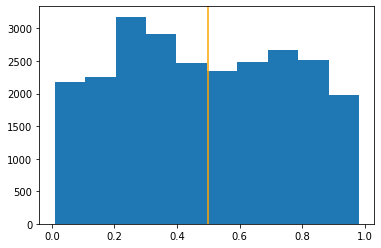

In [37]:
pyplot.hist(y_hat)
_ = pyplot.axvline(x=0.5, color="orange")

Use ROC instead of simple accuracy 

In [38]:
# from sickit-learn
pct_auc = roc_auc_score(y_valid, y_hat) * 100.0
'{:0.2f}'.format(pct_auc)

'76.61'

In [39]:
from sklearn.metrics import roc_curve 
fpr , tpr , thresholds = roc_curve ( y_valid , y_hat)

In [40]:
# false positive rate
fpr

array([0.     , 0.     , 0.     , ..., 0.9976 , 0.99776, 1.     ])

In [41]:
# True positive rate
tpr

array([0.00e+00, 8.00e-05, 1.52e-03, ..., 1.00e+00, 1.00e+00, 1.00e+00])

In [42]:
thresholds

array([1.9812567 , 0.98125666, 0.9786539 , ..., 0.01241192, 0.01240715,
       0.00927779], dtype=float32)

data frame

In [43]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)),
    columns=['y_hat', 'y'])

In [44]:
len(ydf)

25000

In [41]:
ydf.head(10)

,y_hat,y
0,0.056158,0
1,0.996887,1
2,0.873207,1
3,0.842341,0
4,0.976890,1
5,0.780034,1
6,0.968682,1
7,0.008423,0
8,0.966701,0
9,0.971602,1


In [45]:
# false positives
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(1)

,y_hat,y
75,0.955365,0


In [43]:

' '.join([index_word[id] for id in x_valid[75]])

"pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad unk unk adventures unk unk unk unk unk unk unk unk unk unk unk unk unk i've yet run across unk would unk unk look far unk wide unk find anything unk unk unk level unk unk unk display unk unk unk acting \x96 bad editing \x96 bad direction \x96 bad special effects \x96 bad unk laughable plot \x96 bad lighting \x96 bad cinematography \x96 bad costume design \x96 bad unk silly everything else \x96 bad watching unk adventures unk unk unk unk unk enjoyable unk unk root unk even unk unk fan unk bad movies unk unk real unk test unk unk unk unk either unk unk lou unk unk unk any exist unk unk eight things unk learned unk watching unk adventures unk unk unk unk 1 unk unk don't unk unk budget unk 

In [46]:
# false negatives
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
2,0.024815,1
118,0.085376,1
167,0.055546,1
187,0.067159,1
224,0.044641,1
402,0.038199,1
483,0.055400,1
603,0.067669,1
755,0.096873,1
1050,0.057730,1


In [47]:
' '.join([index_word[id] for id in x_valid[973]])

"unk character unk my opinion unk unk unk them did bad another thing unk unk notice unk unk read unk these comment unk unk unk person unk comment unk alan 5 shadow which made him look even better unk unk pretty much had unk through unk whole unk unk would give unk unk unk 9 unk unk 10 another unk unk my opinions unk unk unk would been better unk there wasn't any sex still unk unk alright love unk scene were unk says unk sh t when unk unk setting unk unk car unk see them unk unk mirror"

Conclusion: 

ROC is '76.61'

Compared with Dense network ROC of '92.61'
 

Need of Recurrent Neural networks, which take into account the sequence of words.

Next module: Try LSTM